# INSTALLING ALL LIBRARIES

In [59]:
# computing
import numpy as np
import pandas as pd
import time

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image 
import PIL 

# background removal
from rembg import remove

# feature extraction
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte, exposure

# modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import accuracy_score

# load/save file
import os
import pickle

## Pickle

In [60]:
def load_file_pickle(filename):
    file_pickle = pickle.load(open(filename, 'rb'))
    return file_pickle

def save_file_pickle(data, filename):
    pickle.dump(data, open(filename, 'wb'))

In [61]:
SVM_WG_FILE_PICKLE = "svm_with_glcm_model.pkl"
SVM_WOG_FILE_PICKLE = "svm_without_glcm_model.pkl"
SVM_WG_NOBG_FILE_PICKLE = "svm_with_glcm_nobg_model.pkl"
SVM_WOG_NOBG_FILE_PICKLE = "svm_without_glcm_nobg_model.pkl"
SVM_WOG_SCALER_FILE_PICKLE = "svm_without_glcm_scaler.pkl"
SVM_WOG_NOBG_SCALER_FILE_PICKLE = "svm_without_glcm_nobg_scaler.pkl"
SVM_WGP_FILE_PICKLE = "svm_with_glcm_plt_model.pkl" # power law gamma transformation

## Testing GLCM

In [62]:
# TESTING GLCM
input_matrix = np.array([[0, 0, 1],
                          [1, 2, 3],
                          [2, 3, 2]])

glcm = graycomatrix(input_matrix, 
                    distances=[1], 
                    angles=[0], 
                    levels=4,
                    symmetric=True, 
                    normed=True)

print(glcm[:,:,0,0])

[[0.16666667 0.08333333 0.         0.        ]
 [0.08333333 0.         0.08333333 0.        ]
 [0.         0.08333333 0.         0.25      ]
 [0.         0.         0.25       0.        ]]


# Loading Image

In [63]:
# !rembg p -m u2net dataset/train_nobg/freshapples dataset/train_nobg/freshapples_nobg

In [64]:
# !rembg p -m u2net dataset/train_nobg/rottenapples dataset/train_nobg/rottenapples_nobg

In [65]:
# !rembg p -m u2net dataset/test_nobg/freshapples dataset/test_nobg/freshapples_nobg

In [66]:
# !rembg p -m u2net dataset/test_nobg/rottenapples dataset/test_nobg/rottenapples_nobg

In [67]:
# loading image function
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resizing(image, 300)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = os.listdir(path)
    images = np.array([import_image(path + '/' + file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

In [68]:
labels = ('freshapples','rottenapples')

raw_X_train = np.empty((0, 300, 300, 3), np.uint8)
raw_Y_train = np.empty((0))

raw_X_test = np.empty((0, 300, 300, 3), np.uint8)
raw_Y_test = np.empty((0))

# folder_path = "../dataset/train/" # for local used
# folder_path_train = "drive/MyDrive/Colab Notebooks/dataset/train/" # for drive used
# folder_path_test = "drive/MyDrive/Colab Notebooks/dataset/test/"

folder_path_train = "dataset/train/" # for drive used
folder_path_test = "dataset/test/"

for label in labels:
    # for train
    dataset_path_train = folder_path_train + label

    temp_X_train, temp_y_train = import_data(label, dataset_path_train)

    print("Size of train ", label, ":", temp_X_train.shape[0])
    
    raw_X_train = np.append(raw_X_train, temp_X_train, axis=0)
    raw_Y_train = np.append(raw_Y_train, temp_y_train, axis=0)

    # for test
    dataset_path_test = folder_path_test + label

    temp_X_test, temp_y_test = import_data(label, dataset_path_test)

    print("Size of test", label, ":", temp_X_test.shape[0])
    
    raw_X_test = np.append(raw_X_test, temp_X_test, axis=0)
    raw_Y_test = np.append(raw_Y_test, temp_y_test, axis=0)

print("Size of raw Test : ", raw_X_test.shape[0])
print("Size of raw Train : ", raw_X_train.shape[0])

Size of train  freshapples : 1693
Size of test freshapples : 395
Size of train  rottenapples : 2342
Size of test rottenapples : 601
Size of raw Test :  996
Size of raw Train :  4035


In [69]:
# 0 dimension -> showing all images
# 1st dimension -> spesific image
# 2nd dimension -> all pixel rgb color in 1 image
# 3rd dimension -> spesific pixel rgb
# 4th dimension -> spesific r/g/b
print(temp_X_test.shape)
print(raw_X_test[1][0][0])
output = Image.fromarray(raw_X_test[1])
output = remove(output)
output.save("output.png")

(601, 300, 300, 3)
[0 0 0]


### Showing some images

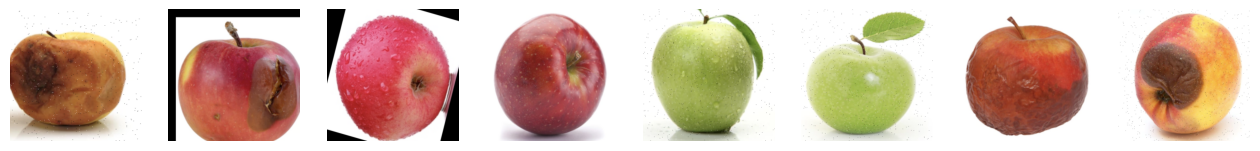

In [70]:
np.random.seed(42) #42 ascii nya bintang

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1

for i in range(1, columns*rows + 1):
    img = np.array(raw_X_train[np.random.randint(0, raw_X_train.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

### Showing Image RGB

Text(0.5, 0.98, 'Original & RGB image channels')

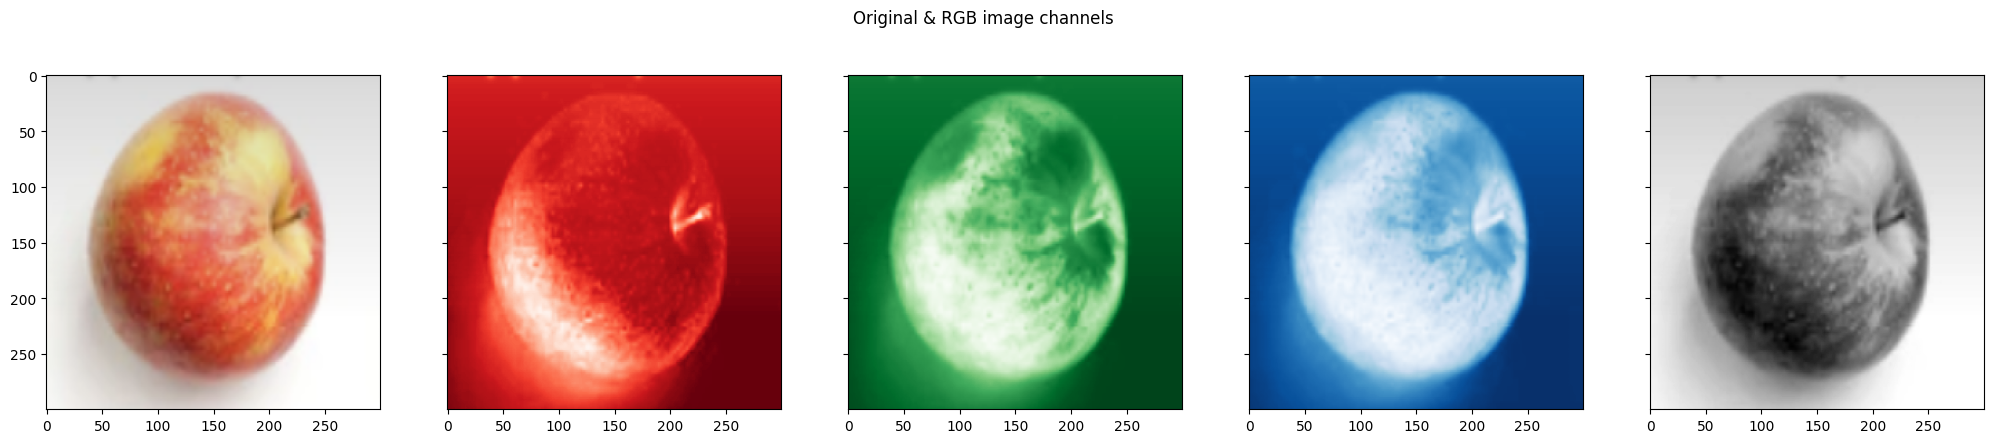

In [71]:
fig, (im1, im2, im3, im4, im5) = plt.subplots(1, 5, sharey=True)
fig.set_figwidth(25) 

img = np.array(raw_X_train[np.random.randint(0, raw_X_train.shape[0]), :])
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

im1.imshow(img)  #Original image
im2.imshow(img[:, : , 0], cmap='Reds') #Red
im3.imshow(img[:, : , 1], cmap='Greens') #Green
im4.imshow(img[:, : , 2], cmap='Blues') #Blue
im5.imshow(img_gray, cmap='gray')
fig.suptitle('Original & RGB image channels')

In [72]:
im = Image.fromarray(img_gray)
im.save("img_gray.jpeg")

output = remove(im)
print(type(img_gray))
output.save("output.png")

<class 'numpy.ndarray'>


Text(0.5, 0.98, 'Grayscale image')

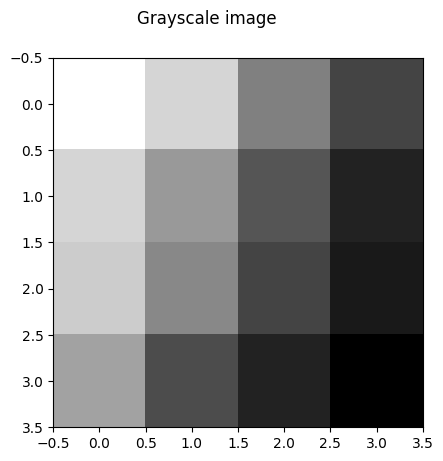

In [73]:
fig, im1 = plt.subplots(1, 1, sharey=True)
fig.set_figwidth(25)
im1.imshow(img_gray[85:89, 54:58], cmap='gray')
fig.suptitle('Grayscale image') 

In [74]:
print(img_gray[85:89, 54:58])

[[225 220 210 203]
 [220 213 205 199]
 [219 211 203 198]
 [214 204 199 195]]


### Showing Histogram

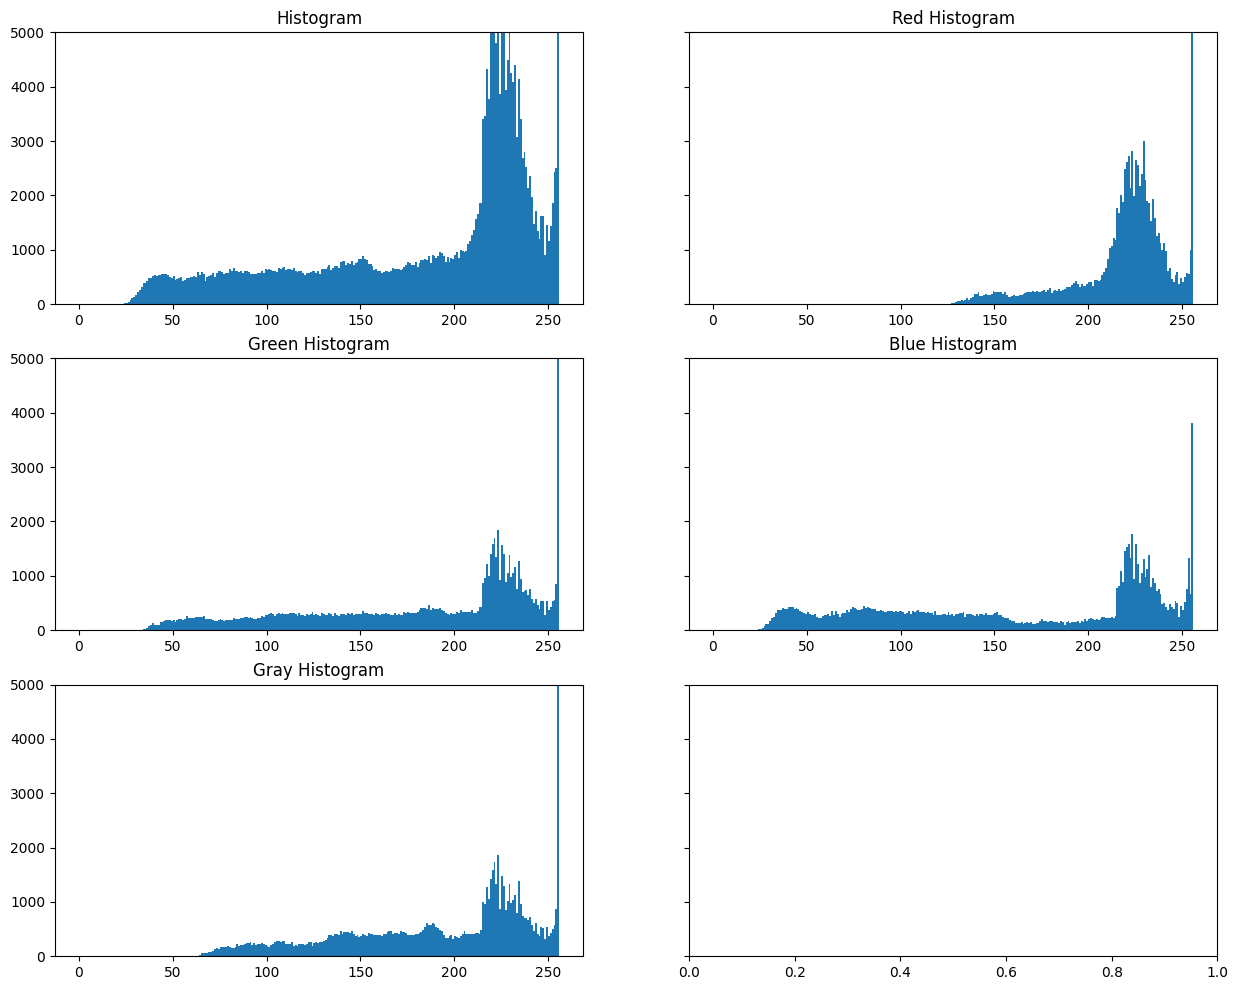

In [75]:
### Checking Histogram (normal color, RGB, grayscale) for knowing contrast and brightness
fig, ((im1, im2), (im3, im4), (im5, im6)) = plt.subplots(nrows=3, ncols=2, sharey=True)
fig.set_figheight(12)
fig.set_figwidth(15)

# show the plotting graph of an image
im1.hist(img.ravel(),256,[0,256], label='RGB') # ravel is for flattening array from 2d to 1d array
im1.set_ylim(0,5000) # limit height of histogram
im1.set_title('Histogram')
im2.hist(img[:,:,0].ravel(),256,[0,256], label='R')
im2.set_title('Red Histogram')
im3.hist(img[:,:,1].ravel(),256,[0,256], label='G')
im3.set_title('Green Histogram')
im4.hist(img[:,:,2].ravel(),256,[0,256], label='B')
im4.set_title('Blue Histogram')
im5.hist(img_gray.ravel(),256,[0,256], label='Gray')
im5.set_title('Gray Histogram')
plt.show()

# Feature Extaction (GLCM)
preprocessing:
- resizing to 300x300
- grayscaling

augmentation(from dataset):
- rotate 15, 45, 60, 75
- salt and pepper
- translation
- vertical flip

In [76]:
# power law gamma transformation (preprocessing)
def power_law_transformation(img, gamma):
	img_plt = np.array(255*(img/255)**gamma, dtype='uint8')
	return img_plt

def power_law_transformation_2(img, gamma):
	img_plt = np.power(img, gamma)
	return img_plt

def power_law_transformation_3(img, gamma):
	img_plt = exposure.adjust_gamma(img, gamma)
	return img_plt

# glcm properties
def contrast_feature(matrix_coocurrence):
	contrast = graycoprops(matrix_coocurrence, 'contrast')
	return contrast

def dissimilarity_feature(matrix_coocurrence):
	dissimilarity = graycoprops(matrix_coocurrence, 'dissimilarity')	
	return dissimilarity

def homogeneity_feature(matrix_coocurrence):
	homogeneity = graycoprops(matrix_coocurrence, 'homogeneity')
	return homogeneity

def energy_feature(matrix_coocurrence):
	energy = graycoprops(matrix_coocurrence, 'energy')
	return energy

def correlation_feature(matrix_coocurrence):
	correlation = graycoprops(matrix_coocurrence, 'correlation')
	return correlation

def asm_feature(matrix_coocurrence):
	asm = graycoprops(matrix_coocurrence, 'ASM')
	return asm

def gray_convertion(rgb_img):
	return cv2.cvtColor(rgb_img,cv2.COLOR_RGB2GRAY)

def glcm_extraction(img):
	glcm_feature = np.empty((0, 16), np.uint8)

	for i in range(img.shape[0]):
		img_gray = gray_convertion(img[i])
		# img_gray = remove(img_gray)
		# img_gray = np.array(img_gray)
		
		#image = img_gray # 69.54% (16-bit)
		image = img_as_ubyte(img_gray) # 69.54% (16-bit), img as ubyte to convert image with value 0-255

		# bins = np.array([0, 32, 64, 96, 128, 160, 192, 224, 255]) #8-bit = 66.9%
		bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit = 69.54%
		# bins = np.array([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 255]) #32-bit = 69.54%
		inds = np.digitize(image, bins) # buat nyari masing2 nilai dari image ada di index berapa kalau di array bins (pake indo biar ga ribet wkwk)

		max_value = inds.max()+1 # max value = 256
		matrix_coocurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)
		
		img_energy = energy_feature(matrix_coocurrence)
		img_correlation = correlation_feature(matrix_coocurrence)
		img_contrast = contrast_feature(matrix_coocurrence)
		img_homogenity = homogeneity_feature(matrix_coocurrence)
		# without dissimilarity (16-bit) = 69.54%
		# with dissimilarity (16-bit) = 68.94%
		# img_dissimilarity = dissimilarity_feature(matrix_coocurrence)
		# img_asm = asm_feature(matrix_coocurrence)

		temp_glcm_feature = np.empty(0)

		temp_glcm_feature = np.append(img_energy, img_correlation)
		temp_glcm_feature = np.append(temp_glcm_feature, img_contrast)
		temp_glcm_feature = np.append(temp_glcm_feature, img_homogenity)
		# temp_glcm_feature = np.append(temp_glcm_feature, img_dissimilarity)
		# temp_glcm_feature = np.append(temp_glcm_feature, img_asm)

		glcm_feature = np.append(glcm_feature, [temp_glcm_feature], axis=0)
	
	return glcm_feature
	

### Feature Testing

In [77]:
# source : https://github.com/renbooo/Gray-Level-Cooccurrence-Matrix/blob/master/glcm_fix.py
image = img_as_ubyte(img_gray)

bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
inds = np.digitize(image, bins)

max_value = inds.max()+1
matrix_coocurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

print(energy_feature(matrix_coocurrence))
print(correlation_feature(matrix_coocurrence))
print(contrast_feature(matrix_coocurrence))
print(homogeneity_feature(matrix_coocurrence))
print(dissimilarity_feature(matrix_coocurrence))
print(asm_feature(matrix_coocurrence))

[[0.29945806 0.29090222 0.30276149 0.29311088]]
[[0.99515185 0.99300153 0.99590207 0.99362097]]
[[0.09657748 0.13962931 0.08177258 0.12726927]]
[[0.95280825 0.93379604 0.95951505 0.9378687 ]]
[[0.09474916 0.13361148 0.08110368 0.12476371]]
[[0.08967513 0.0846241  0.09166452 0.08591399]]


### Feature Extraction

In [78]:
# glcm_feature = np.empty((0, 16), np.uint8)

glcm_feature = glcm_extraction(raw_X_train)

print(glcm_feature)
glcm_feature.shape
inds.max()+1   

[[0.3689621  0.36280636 0.37019465 ... 0.89058227 0.91525233 0.8891984 ]
 [0.35446676 0.34900676 0.35691431 ... 0.93066644 0.95162644 0.93770576]
 [0.29377118 0.28531848 0.29404457 ... 0.89387275 0.91849976 0.89240691]
 ...
 [0.32799973 0.31840303 0.33044106 ... 0.8707836  0.90936986 0.87048686]
 [0.36991467 0.36437832 0.37237129 ... 0.94171031 0.96217536 0.94259276]
 [0.44013292 0.43389755 0.44363952 ... 0.90466669 0.93584143 0.90572738]]


18

In [79]:
for i in range(1):
    j = random.randrange(len(glcm_feature))
    print(raw_Y_train[j])
    print(glcm_feature[j])

rottenapples
[0.51518671 0.50961518 0.51566818 0.5101992  0.9949326  0.99113924
 0.99481138 0.99183197 0.19593088 0.34306104 0.20068004 0.31623807
 0.93789735 0.91035503 0.93402717 0.9148821 ]


In [80]:
for i in range(5):
    j = random.randrange(len(glcm_feature))
    print(raw_Y_train[j])
    print(glcm_feature[j])

rottenapples
[0.39169198 0.38704443 0.39350068 0.38632055 0.99149841 0.97901862
 0.98695144 0.97862337 0.5074136  1.25057885 0.77725753 1.26174204
 0.96116315 0.94561701 0.96420593 0.9429734 ]
rottenapples
[0.55340193 0.54820435 0.55558256 0.54877974 0.9901048  0.9844562
 0.99194963 0.98672249 0.20713489 0.3257458  0.16851728 0.27825192
 0.9161587  0.89263139 0.93029261 0.89977451]
freshapples
[0.28751464 0.28017181 0.28929576 0.2773521  0.9911721  0.98477036
 0.99152631 0.98384681 0.46419175 0.79700451 0.44556299 0.84532611
 0.92648611 0.90496495 0.92986592 0.8966665 ]
freshapples
[0.33439799 0.32246114 0.33215655 0.32304511 0.9963278  0.99312816
 0.99594417 0.99386595 0.18149387 0.33972774 0.20071349 0.3032852
 0.9331646  0.89569451 0.92210637 0.89998815]
rottenapples
[0.32598207 0.3186881  0.3265094  0.31665902 0.99686394 0.99530932
 0.99685638 0.99490154 0.14016722 0.209416   0.14054627 0.22762609
 0.942244   0.91961838 0.93963409 0.91431004]


# Modelling (SVM+GLCM)

In [81]:
# Just load model without re-training if you want
svm_wg = load_file_pickle(SVM_WG_FILE_PICKLE)

In [82]:
start_svm_wg = time.time()
# create parameter tuning
num_feature = glcm_feature.shape[1]
_var = glcm_feature.var()
_scale = round(1 / (num_feature * _var), 5) # 5 point accuracy
_dist = round(_scale * 10 / 100, 5)
_scale_1 = round(_scale - (2 * _dist), 5)
_scale_2 = round(_scale - _dist, 5)
_scale_3 = round(_scale + _dist, 5)
_scale_4 = round(_scale + (2 * _dist), 5)

_gamma = [_scale_1, _scale_2, _scale, _scale_3, _scale_4]
_c = [1, 3, 6, 10, 15]

print(_scale)
print(_dist)
print(_gamma)
print(_var)

0.6841
0.06841
[0.54728, 0.61569, 0.6841, 0.75251, 0.82092]
0.09136035215632551


In [83]:
svm_wg_params = {
    'C': _c,
    'gamma': _gamma
}
# cv = cross validation (5 C & 5 Gamma = 125 cv), setiap kombinasi c & gamma diuji 5x
svm_wg = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_wg_params, cv=5, verbose=3)

In [84]:
svm_wg.fit(glcm_feature,raw_Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ................C=1, gamma=0.54728;, score=0.701 total time=   2.6s
[CV 2/5] END ................C=1, gamma=0.54728;, score=0.690 total time=   2.7s
[CV 3/5] END ................C=1, gamma=0.54728;, score=0.665 total time=   2.7s
[CV 4/5] END ................C=1, gamma=0.54728;, score=0.601 total time=   2.6s
[CV 5/5] END ................C=1, gamma=0.54728;, score=0.621 total time=   2.7s
[CV 1/5] END ................C=1, gamma=0.61569;, score=0.700 total time=   3.0s


KeyboardInterrupt: 

In [ ]:
end_svm_wg = time.time()

In [ ]:
time_elapsed_wg = end_svm_wg-start_svm_wg
print("Best Model:", svm_wg.best_estimator_)
print("Best CV Score:", svm_wg.best_score_)
print("Total Elapsed Time:", time_elapsed_wg)

Best Model: SVC(C=15, gamma=0.98093, probability=True)
Best CV Score: 0.7231722428748452
Total Elapsed Time: 330.7714548110962


In [ ]:
cv_results_df = pd.DataFrame(svm_wg.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
15_0.98093,"{'C': 15, 'gamma': 0.98093}",1,0.723172,0.015706
15_1.07011,"{'C': 15, 'gamma': 1.07011}",2,0.722924,0.015370
15_0.89175,"{'C': 15, 'gamma': 0.89175}",3,0.721437,0.014691
15_0.80257,"{'C': 15, 'gamma': 0.80257}",4,0.717720,0.014837
10_1.07011,"{'C': 10, 'gamma': 1.07011}",4,0.717720,0.013785
15_0.71339,"{'C': 15, 'gamma': 0.71339}",6,0.717720,0.014481
10_0.98093,"{'C': 10, 'gamma': 0.98093}",7,0.717472,0.015197
10_0.89175,"{'C': 10, 'gamma': 0.89175}",8,0.713259,0.013901
10_0.71339,"{'C': 10, 'gamma': 0.71339}",9,0.713011,0.015725


### Saving Model

In [ ]:
save_file_pickle(svm_wg, SVM_WG_FILE_PICKLE)

# Predicting (SVM+GLCM)
C=15, gamma=0.82092

### Feature Extraction

In [ ]:
glcm_feature_predict = glcm_extraction(raw_X_test)

print(glcm_feature_predict)
glcm_feature_predict.shape
inds.max()+1   

[[0.43688026 0.43012493 0.43839581 ... 0.91230093 0.93668074 0.91262626]
 [0.55565825 0.55124378 0.55570555 ... 0.93904551 0.95226299 0.93635661]
 [0.46568347 0.45793521 0.46328447 ... 0.92819918 0.94320063 0.93355593]
 ...
 [0.39128134 0.38497684 0.39613788 ... 0.84151934 0.89283762 0.84000369]
 [0.42500632 0.41968699 0.42599883 ... 0.90949636 0.93127085 0.90295635]
 [0.37930806 0.36954998 0.38049645 ... 0.86247814 0.89705825 0.86496353]]


15

### Predicting

#### Testing

In [ ]:
test = svm_wg.predict_proba(np.reshape(glcm_feature_predict[0], (1,-1)))
test

array([[0.46698137, 0.53301863]])

In [ ]:
glcm_feature_predict[0]

array([0.43688026, 0.43012493, 0.43839581, 0.43060094, 0.98826558,
       0.98189284, 0.99044284, 0.98177864, 0.34272018, 0.52853995,
       0.27913043, 0.53187325, 0.93141109, 0.91230093, 0.93668074,
       0.91262626])

In [ ]:
test_acc = round(test.max() * 100, 2)
test_acc

53.3

#### Predicting Accuracy (SVM+GLCM)

In [ ]:
Y_predict_wg = svm_wg.predict(glcm_feature_predict)

In [ ]:
acc_wg = accuracy_score(raw_Y_test, Y_predict_wg)
print("Accuracy score:", acc_wg)

Accuracy score: 0.7329317269076305


# Modelling (SVM)

In [ ]:
# Just load model without re-training in case you need fast
svm_wog = load_file_pickle(SVM_WOG_FILE_PICKLE)

### Resizing & Flattening

In [ ]:
size = 32
img_resize_flatten = np.empty((0,size*size*3), np.uint8)

print(raw_X_train[0].shape)
for i in range(raw_X_train.shape[0]):
    # image = img_as_ubyte(raw_X_test[i])
    img_resized = resizing(raw_X_train[i],32)
    img_flat = img_resized.ravel()
    img_resize_flatten = np.append(img_resize_flatten, [img_flat], axis=0)

print(img_resize_flatten.shape)

(300, 300, 3)
(4035, 3072)


### MinMaxScaler Normalization

In [ ]:
svm_wog = load_file_pickle(SVM_WOG_SCALER_FILE_PICKLE)

In [ ]:
scaler = MinMaxScaler()
img_resize_flatten_scale = scaler.fit_transform(img_resize_flatten, raw_Y_train)

In [ ]:
save_file_pickle(scaler, SVM_WOG_SCALER_FILE_PICKLE)

### Modelling

In [ ]:
start_svm_wog = time.time()
num_feature = img_resize_flatten_scale.shape[1]
_var = img_resize_flatten_scale.var()
_scale = round(1 / (num_feature * _var), 5) # 5 point accuracy
_dist = round(_scale * 10 / 100, 5)
_scale_1 = round(_scale - (2 * _dist), 5)
_scale_2 = round(_scale - _dist, 5)
_scale_3 = round(_scale + _dist, 5)
_scale_4 = round(_scale + (2 * _dist), 5)

# _gamma = [_scale_1, _scale_2, _scale, _scale_3, _scale_4]
_gamma = [_scale]
_c = [1, 3, 6, 10, 15]

print(_scale)
print(_dist)
print(_gamma)
print(_var)
print(num_feature)

0.00278
0.00028
[0.00222, 0.0025, 0.00278, 0.00306, 0.00334]
0.11717591648554329
3072


In [ ]:
svm_wog_params = {
    'C': _c,
}
# cv = cross validation (5 C & 5 Gamma = 125 cv), setiap kombinasi c & gamma diuji 5x
svm_wog = GridSearchCV(estimator=SVC(kernel='rbf', probability=True,gamma='auto') , param_grid=svm_wog_params, cv=2, verbose=3)
# cv / cross validation turned off cause it takes long time each itteration (1.6 min/itteration)

In [ ]:
svm_wog.fit(img_resize_flatten_scale,raw_Y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV 1/2] END ................C=1, gamma=0.00222;, score=0.812 total time=  29.6s
[CV 2/2] END ................C=1, gamma=0.00222;, score=0.767 total time=  31.3s
[CV 1/2] END .................C=1, gamma=0.0025;, score=0.831 total time=  30.1s
[CV 2/2] END .................C=1, gamma=0.0025;, score=0.773 total time=  32.2s
[CV 1/2] END ................C=1, gamma=0.00278;, score=0.839 total time=  29.1s
[CV 2/2] END ................C=1, gamma=0.00278;, score=0.780 total time=  28.2s
[CV 1/2] END ................C=1, gamma=0.00306;, score=0.838 total time=  27.2s
[CV 2/2] END ................C=1, gamma=0.00306;, score=0.784 total time=  26.3s
[CV 1/2] END ................C=1, gamma=0.00334;, score=0.832 total time=  27.5s
[CV 2/2] END ................C=1, gamma=0.00334;, score=0.784 total time=  29.9s
[CV 1/2] END ................C=3, gamma=0.00222;, score=0.851 total time=  25.5s
[CV 2/2] END ................C=3, gamma=0.00222;

GridSearchCV(cv=2, estimator=SVC(probability=True),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': [0.00222, 0.0025, 0.00278, 0.00306, 0.00334]},
             verbose=3)

In [ ]:
end_svm_wog = time.time()

In [ ]:
time_elapsed_wog = end_svm_wog-start_svm_wog
print("Best Model:", svm_wog.best_estimator_)
print("Best CV Score:", svm_wog.best_score_)
print("Total Elapsed Time:", time_elapsed_wog)

Best Model: SVC(C=10, gamma=0.00222, probability=True)
Best CV Score: 0.8515406458384209
Total Elapsed Time: 1241.3566722869873


In [ ]:
cv_results_df = pd.DataFrame(svm_wog.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
10_0.00222,"{'C': 10, 'gamma': 0.00222}",1,0.851541,0.033494
15_0.00222,"{'C': 15, 'gamma': 0.00222}",2,0.851292,0.035229
15_0.0025,"{'C': 15, 'gamma': 0.0025}",3,0.847327,0.035726
6_0.00222,"{'C': 6, 'gamma': 0.00222}",4,0.844354,0.033248
6_0.0025,"{'C': 6, 'gamma': 0.0025}",5,0.843858,0.032752
10_0.0025,"{'C': 10, 'gamma': 0.0025}",6,0.843362,0.032753
15_0.00278,"{'C': 15, 'gamma': 0.00278}",7,0.840141,0.032506
6_0.00278,"{'C': 6, 'gamma': 0.00278}",8,0.837910,0.032258
10_0.00278,"{'C': 10, 'gamma': 0.00278}",9,0.836423,0.032754


In [ ]:
save_file_pickle(svm_wog, SVM_WOG_FILE_PICKLE)

# Predicting (SVM)
C=1, gamma=0.00284

In [ ]:
size = 32
img_resize_flatten_predict = np.empty((0,size*size*3), np.uint8) # flattening with 3 color (RGB)

print(raw_X_test[0].shape)
for i in range(raw_X_test.shape[0]):
    # image = img_as_ubyte(raw_X_test[i])
    img_resized = resizing(raw_X_test[i],32)
    img_flat = img_resized.ravel()
    img_resize_flatten_predict = np.append(img_resize_flatten_predict, [img_flat], axis=0)

print(img_resize_flatten_predict.shape)

(300, 300, 3)
(996, 3072)


In [ ]:
img_resize_flatten_predict_scale = scaler.transform(img_resize_flatten_predict)

In [ ]:
Y_predict_wog = svm_wog.predict(img_resize_flatten_predict_scale)

In [ ]:
acc_wog = accuracy_score(raw_Y_test, Y_predict_wog)
print("Accuracy score:", acc_wog)

Accuracy score: 0.9668674698795181


In [ ]:
compare_df = pd.DataFrame({"Model_SVM": ["Without GLCM", "With GLCM"],
                          "Accuracy": [acc_wog, acc_wg]})

compare_df

NameError: name 'acc_wg' is not defined

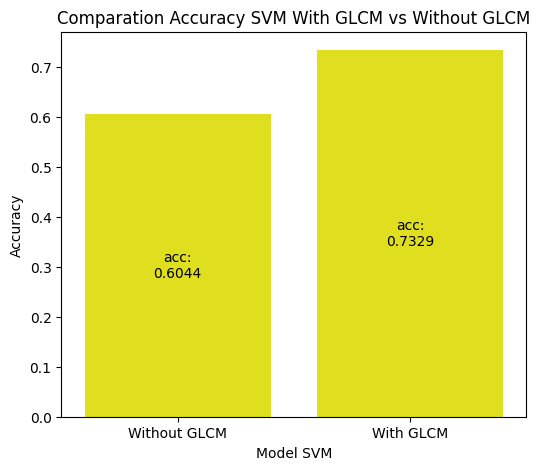

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x = 'Model_SVM',
            y = 'Accuracy',
            data = compare_df,
            ax=ax,
            color='yellow')

ax.bar_label(ax.containers[-1], fmt='acc:\n%.4f', label_type='center')
ax.set(ylabel='Accuracy', xlabel='Model SVM', title="Comparation Accuracy SVM With GLCM vs Without GLCM")

plt.show()

In [ ]:
compare_time_df = pd.DataFrame({"Model_SVM": ["Without GLCM", "With GLCM"],
                          "Time Elapsed": [end_svm_wog-start_svm_wog, end_svm_wg-start_svm_wg]})

compare_time_df

,Model_SVM,Time Elapsed
0,Without GLCM,665.619039
1,With GLCM,330.771455


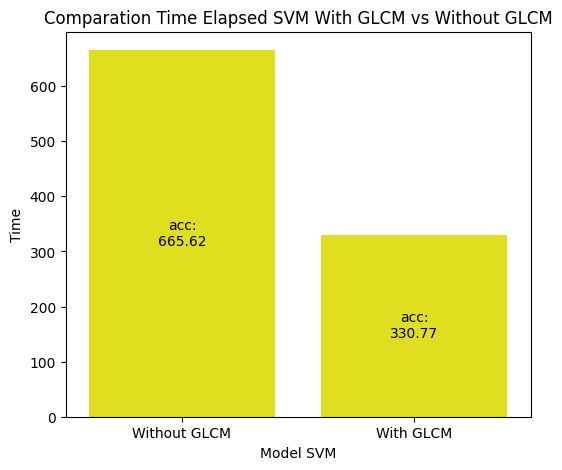

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x = 'Model_SVM',
            y = 'Time Elapsed',
            data = compare_time_df,
            ax=ax,
            color='yellow')

ax.bar_label(ax.containers[-1], fmt='acc:\n%.2f', label_type='center')
ax.set(ylabel='Time', xlabel='Model SVM', title="Comparation Time Elapsed SVM With GLCM vs Without GLCM")

plt.show()

In [ ]:
print('selisih akurasi : ', (acc_wg-acc_wog)*100)
print('selisih waktu : ', time_elapsed_wog-time_elapsed_wg)

selisih akurasi :  12.851405622489963
selisih waktu :  334.8475844860077


# Modelling (SVM+GLCM+PLT)

## Feature Extraction

In [505]:
# feature extraction
# gamma: 0.4, 0.8, 1.2, 1.6, 2.0 (def power_law_transformation)
# 0.4 = 0.7238
# 0.8 = 0.7228
# 1.2 = 0.7279
# 1.6 = 0.7279
# 2.0 = 0.7218

# gamma: 2, 3, 4 (def power_law_transformation_2)
# 2 = 0.6857
# 3 = 0.6947
# 4 = 0.6656

# gamma: 0.4, 0.8, 1.2, 1.6, 2.0 (def power_law_transformation_3)
# 0.4 = 0.7238
# 0.8 = 0.7228
# 1.2 = 0.7279
# 1.6 = 0.7279
# 2.0 = 0.7218
gamma_plt = 1.2
img_plt = power_law_transformation(raw_X_train, gamma_plt)
glcm_plt_feature = glcm_extraction(img_plt)

## Modelling

In [506]:
# Just load model without re-training if you want
svm_wgp = load_file_pickle(SVM_WGP_FILE_PICKLE)

In [507]:
# create parameter tuning
num_feature = glcm_plt_feature.shape[1]
_var = glcm_plt_feature.var()
_scale = round(1 / (num_feature * _var), 5) # 5 point accuracy
_dist = round(_scale * 10 / 100, 5)
_scale_1 = round(_scale - (2 * _dist), 5)
_scale_2 = round(_scale - _dist, 5)
_scale_3 = round(_scale + _dist, 5)
_scale_4 = round(_scale + (2 * _dist), 5)

_gamma = [_scale_1, _scale_2, _scale, _scale_3, _scale_4]
_c = [1, 3, 6, 10, 15]

print(_scale)
print(_dist)
print(_gamma)
print(_var)

0.67009
0.06701
[0.53607, 0.60308, 0.67009, 0.7371, 0.80411]
0.09327055410700372


In [508]:
svm_wgp_params = {
    'C': _c,
    'gamma': _gamma
}
# cv = cross validation (5 C & 5 Gamma = 125 cv), setiap kombinasi c & gamma diuji 5x
svm_wgp = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_wgp_params, cv=5, verbose=3)

In [509]:
svm_wgp.fit(glcm_plt_feature,raw_Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ................C=1, gamma=0.53607;, score=0.695 total time=   2.6s
[CV 2/5] END ................C=1, gamma=0.53607;, score=0.694 total time=   2.6s
[CV 3/5] END ................C=1, gamma=0.53607;, score=0.663 total time=   2.5s
[CV 4/5] END ................C=1, gamma=0.53607;, score=0.599 total time=   2.5s
[CV 5/5] END ................C=1, gamma=0.53607;, score=0.608 total time=   2.5s
[CV 1/5] END ................C=1, gamma=0.60308;, score=0.693 total time=   2.5s
[CV 2/5] END ................C=1, gamma=0.60308;, score=0.693 total time=   2.5s
[CV 3/5] END ................C=1, gamma=0.60308;, score=0.667 total time=   2.6s
[CV 4/5] END ................C=1, gamma=0.60308;, score=0.597 total time=   2.5s
[CV 5/5] END ................C=1, gamma=0.60308;, score=0.608 total time=   2.5s
[CV 1/5] END ................C=1, gamma=0.67009;, score=0.684 total time=   2.6s
[CV 2/5] END ................C=1, gamma=0.67009

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': [0.53607, 0.60308, 0.67009, 0.7371, 0.80411]},
             verbose=3)

In [510]:
print("Best Model:", svm_wgp.best_estimator_)
print("Best CV Score:", svm_wgp.best_score_)

Best Model: SVC(C=15, gamma=0.80411, probability=True)
Best CV Score: 0.6996282527881041


### Saving Model

In [511]:
save_file_pickle(svm_wgp, SVM_WGP_FILE_PICKLE)

# Predicting (SVM+GLCM+PLT)

## Feature Extraction

In [512]:
# feature extraction
# gamma: 0.4, 0.6, 1, 1.4, 1.8, 2.2
img_plt_predict = power_law_transformation(raw_X_test, gamma_plt)
glcm_plt_feature_predict = glcm_extraction(img_plt_predict)

## Predicting

In [513]:
Y_predict_wgp = svm_wgp.predict(glcm_plt_feature_predict)

In [514]:
acc_wgp = accuracy_score(raw_Y_test, Y_predict_wgp)
print("Accuracy score:", acc_wgp)

Accuracy score: 0.7279116465863453


In [515]:
compare_3_df = pd.DataFrame({"Model_SVM": ["Without GLCM", "With GLCM", "With GLCM and PLT"],
                          "Accuracy": [acc_wog, acc_wg, acc_wgp]})

compare_3_df

,Model_SVM,Accuracy
0,Without GLCM,0.639558
1,With GLCM,0.727912
2,With GLCM and PLT,0.727912


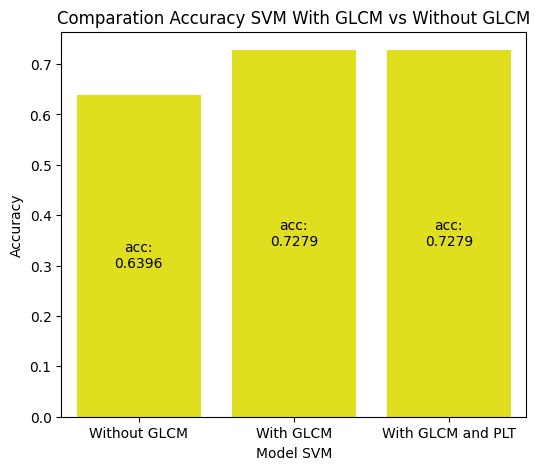

In [516]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x = 'Model_SVM',
            y = 'Accuracy',
            data = compare_3_df,
            ax=ax,
            color='yellow')

ax.bar_label(ax.containers[-1], fmt='acc:\n%.4f', label_type='center')
ax.set(ylabel='Accuracy', xlabel='Model SVM', title="Comparation Accuracy SVM With GLCM vs Without GLCM")

plt.show()

Text(0.5, 0.98, 'Original & PLT image channels')

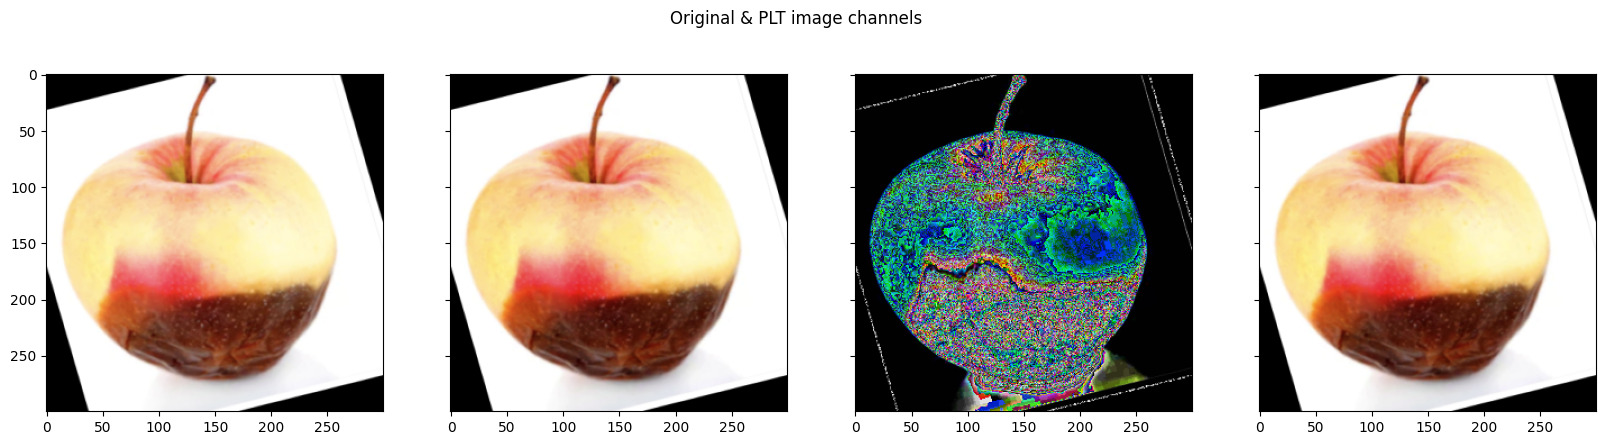

In [517]:
fig, (im1, im2, im3, im4) = plt.subplots(1, 4, sharey=True)
fig.set_figwidth(20) 

img_plt_test = np.power(raw_X_train,2)
img_plt_test_2 = exposure.adjust_gamma(raw_X_train,1.2)

im1.imshow(raw_X_train[1910])  #Original image
im2.imshow(img_plt[1910]) #PLT image
im3.imshow(img_plt_test[1910])
im4.imshow(img_plt_test_2[1910])
fig.suptitle('Original & PLT image channels')